(bayes-workflow-notebook)=
# Modellazione bayesiana

L'obiettivo di questo Capitolo è di introdurre il quadro concettuale dela modellizzazione bayesiana.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import uniform

In [5]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Comprendere i fondamenti

Iniziamo esaminando la definizione precisa di un modello e il suo fondamentale scopo. La modellizzazione emerge come uno strumento essenziale per affrontare la complessità dei sistemi, permettendoci di scomporli in concetti chiave che facilitano la comprensione, l'acquisizione di conoscenza e persino la simulazione dei processi o degli oggetti d'interesse. L'elaborazione di un modello richiede una sinergia articolata di competenze disciplinari e abilità statistiche avanzate. Tale processo si sviluppa attraverso una sequenza di fasi che traducono i fondamenti teorici e le osservazioni empiriche in obiettivi computazionali definiti in maniera chiara. In questo contesto, i dati rivestono il ruolo primario di input, mentre le distribuzioni statistiche agiscono come strumenti matematici fondamentali per formalizzare in modo preciso il modello statistico stesso. Questi strumenti consentono di rappresentare con precisione le interrelazioni tra le variabili coinvolte nel modello e di quantificare l'incertezza associata ai risultati ottenuti.

Passando alle particolarità dei modelli bayesiani, troviamo due aspetti chiave che li caratterizzano:

1. **Descrizione delle quantità sconosciute**: Le grandezze che non sono note vengono modellate mediante l'uso di distribuzioni di probabilità, le quali vengono identificate come i parametri del modello.

2. **Teorema di Bayes per l'aggiornamento**: Il teorema di Bayes viene impiegato per aggiornare i valori dei parametri, tenendo conto dei dati osservati. Questo processo può essere interpretato come una riallocazione delle probabilità, in cui l'informazione raccolta dai dati influisce sull'incertezza associata ai parametri.

Il processo di costruzione di un modello bayesiano può essere articolato in tre passaggi fondamentali:

1. **Progettazione del modello**: A partire dai dati e dalle ipotesi sul loro processo di generazione, si progetta un modello. Questo viene ottenuto tramite la combinazione e la trasformazione di variabili casuali.

2. **Inferenza bayesiana**: Utilizzando il teorema di Bayes, si adatta il modello ai dati disponibili, ottenendo così una distribuzione a posteriori. Tale processo, chiamato inferenza, mira a ridurre l'incertezza sui possibili valori dei parametri in seguito all'osservazione dei dati.

3. **Valutazione e confronto**: Si valuta la validità del modello, verificandone la coerenza rispetto a diversi criteri, inclusi i dati osservati e l'esperienza nel dominio di riferimento. Poiché l'incertezza sui modelli stessi è spesso presente, è consueto confrontare più modelli per giungere a una scelta informata.

In questa sezione della dispensa, esploreremo dettagliatamente ciascuno di questi tre passaggi (per un approfondimento, si rimanda a {cite:t}`baribault2023troubleshooting`).

## L'inferenza bayesiana: dal teorema di Bayes alla distribuzione a posteriori

L'inferenza, in termini più ampi, può essere descritta come il processo di derivazione di conclusioni basate sull'analisi di evidenze e ragionamenti logici. Nel contesto statistico, l'inferenza bayesiana rappresenta una forma specifica di inferenza che si avvale della combinazione di distribuzioni di probabilità per derivare ulteriori distribuzioni di probabilità. Il teorema di Bayes costituisce il fondamento di tale approccio, fornendo una metodologia generale per la stima del valore di un parametro $\theta$ sulla base dei dati osservati $y$:

$$
\underbrace{p(\theta \mid y)}_{\text{posteriore}} = \frac{\overbrace{p(y \mid \theta)}^{\text{verosimiglianza}} \cdot \overbrace{p(\theta)}^{\text{prior}}}{\underbrace{p(y)}_{\text{verosimiglianza marginale}}}.
$$ (eq-bayes-intro)

La funzione di verosimiglianza stabilisce il legame tra i dati osservati e i parametri sconosciuti, mentre la distribuzione a priori esprime l'incertezza preesistente sui parametri prima di effettuare le osservazioni. La moltiplicazione di queste due componenti conduce alla distribuzione a posteriori, che riflette la distribuzione congiunta di tutti i parametri del modello, condizionata ai dati osservati. Il processo che guida la trasformazione dalla distribuzione a priori a quella a posteriori è comunemente identificato come *aggiornamento bayesiano*. Il teorema di Bayes ci indica dunque come utilizzare la probabilità a priori, $ p(\theta) $, di un parametro non osservato o di un insieme di parametri, $ \theta $, e la verosimiglianza, $ p(y \mid \theta) $, dei dati osservati, $ y $, per derivare la probabilità a posteriori, $ p(\theta \mid y) $, dei parametri alla luce dei dati.

## L'aggiornamento bayesiano

Per offrire una spiegazione quantitativa del procedimento di aggiornamento bayesiano, prendiamo in considerazione un esempio pratico: la localizzazione di un aeromobile disperso. In questo capitolo, ci concentriamo esclusivamente sulla comprensione della struttura logica del problema e sulla sua formalizzazione tramite l'impiego di distribuzioni di probabilità. In questa fase, tralasciamo i dettagli implementativi e mettiamo invece l'accento sul significato delle diverse fasi e degli obiettivi del processo di aggiornamento bayesiano. Successivamente, esamineremo le metodologie per conseguire tali obiettivi, approfondendo gli aspetti di natura computazionale.

L'illustrazione coinvolge un ipotetico scenario in cui un aereo è disperso nell'Oceano Pacifico. Ci troviamo in un contesto in cui la latitudine è determinata, ma la longitudine rimane ignota (disponiamo unicamente dell'indicazione della direzione del viaggio, senza conoscere la distanza percorsa). L'obiettivo principale è rifinire la stima della posizione approssimata ($\theta$) dell'aereo. Per raggiungere questo fine, gli operatori di soccorso raccolgono dati dai frammenti dei detriti che sono stati individuati.

Iniziamo il processo con una stima iniziale, definita come *distribuzione a priori*. Questa distribuzione di probabilità rappresenta il nostro grado di conoscenza sulla posizione dell'aereo prima di ricevere ulteriori dati o informazioni.

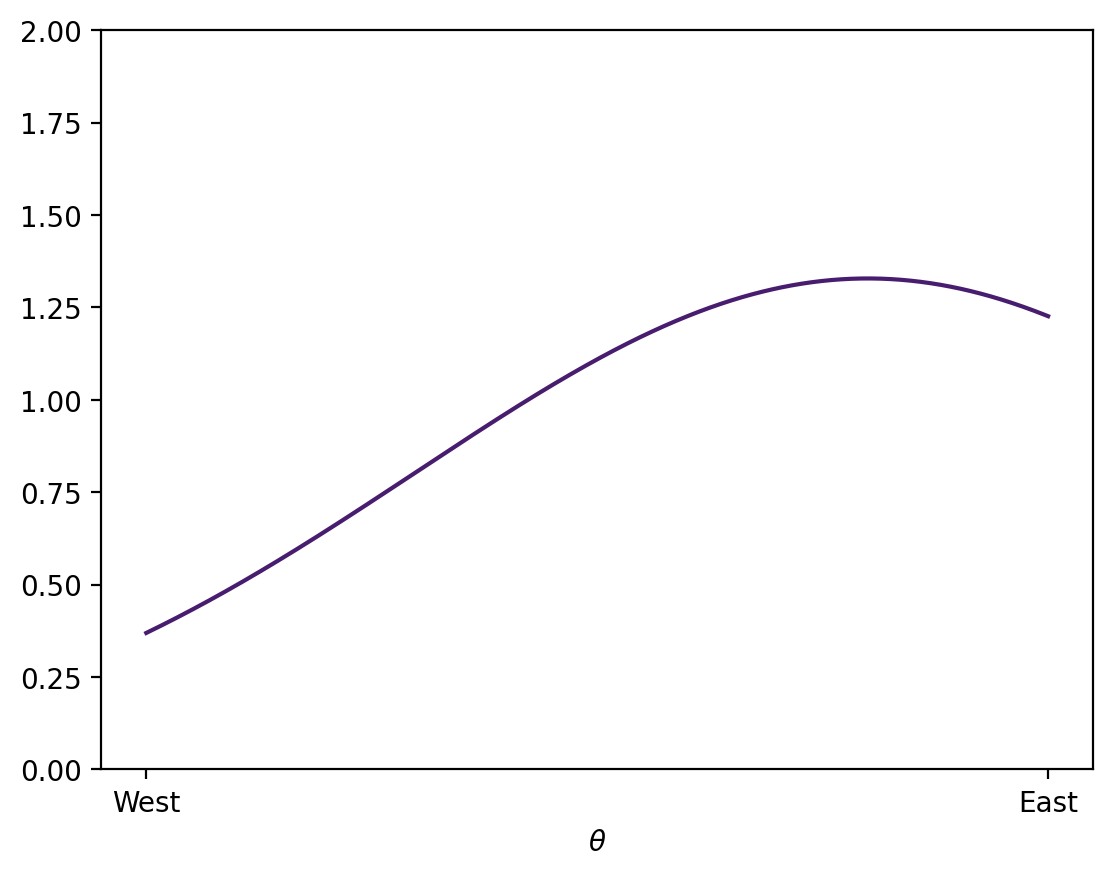

In [6]:
def dnorm_trunc(x, mean=0, sd=1, ll=0, ul=1):
    out = norm.pdf(x, mean, sd) / (norm.cdf(ul, mean, sd) - norm.cdf(ll, mean, sd))
    out[(x > ul) | (x < ll)] = 0
    return out

# Data points for x-axis
x_vals = np.linspace(0, 1, 1000)

# Parameters for the dnorm_trunc function
mean_val = 0.8
sd_val = 0.5

# Calculate the y values using dnorm_trunc function
y_vals = dnorm_trunc(x_vals, mean_val, sd_val)

# Plot the curve
plt.plot(x_vals, y_vals)
plt.ylim(0, 2)
plt.xlabel(r"$\theta$")
plt.ylabel("")
plt.xticks([0, 1], ["West", "East"])
plt.show()

Nel contesto bayesiano, una distribuzione di probabilità assume il compito di rappresentare l'incertezza o le convinzioni che nutriamo riguardo ai molteplici valori possibili che un parametro può assumere. Nel caso attuale, il parametro $\theta$ indica la longitudine associata alla posizione dell'aereo disperso nell'oceano Pacifico. La posizione esatta dell'aereo rimane sconosciuta. Tuttavia, formuliamo delle ipotesi iniziali sulle possibili localizzazioni. Per ogni valore possibile di $\theta$, la distribuzione di probabilità attribuisce un livello di fiducia che rispecchia quanto riteniamo probabile che quel valore specifico rappresenti il vero valore del parametro. I valori di $\theta$ associati a ordinate più elevate nella funzione indicano un grado superiore di fiducia, in quanto riteniamo che tali valori siano più propensi a rappresentare il vero valore del parametro. In contrasto, i valori di $\theta$ associati a ordinate più basse denotano convinzioni più deboli.

Sull'asse $x$ del grafico sopra riportato sono indicati i valori di $\theta$, cioè i diversi possibili valori della longitudine dell'aereo. Le estremità dell'asse delle ascisse sono etichettate come "West" (Ovest) e "East" (Est), per indicare che $\theta$ spazia da ovest a est. Lungo l'asse delle ordinate ($y$), sono tracciati i valori delle densità di probabilità associati a ciascun valore di $\theta$. 

Nel nostro caso specifico, la distribuzione a priori è centrata intorno a $\theta = 0.8$, suggerendo una previsione iniziale che l'aereo sia più verosimilmente situato ad est. Tuttavia, permangono incertezze considerevoli riguardo alla posizione esatta. Possiamo affermare, comunque, che inizialmente riteniamo che sia due volte più probabile che l'aereo si trovi ad est rispetto a ovest.

La scelta della distribuzione a priori rispecchia le convinzioni del ricercatore riguardo al problema in questione. Di conseguenza, diversi ricercatori potrebbero formulare diverse distribuzioni a priori per lo stesso problema, e tale diversità è accettabile, a patto che tali distribuzioni siano ragionevolmente giustificate. Nel prosieguo, scopriremo che nelle analisi Bayesiane, anche con campioni di dimensioni moderate, le varie distribuzioni a priori generano solitamente differenze trascurabili.

Ora, supponiamo di aver raccolto dei detriti nelle posizioni mostrate nel grafico seguente.

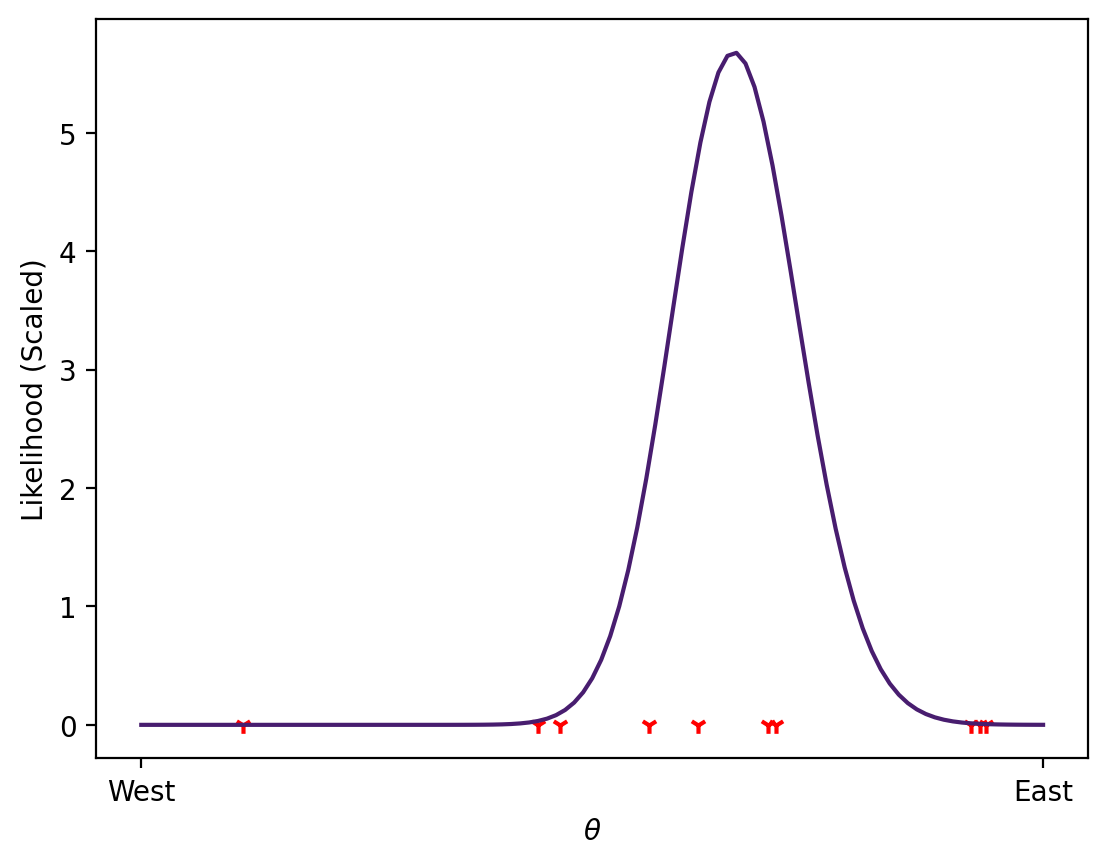

In [7]:
def qnorm_trunc(p, mean=0, sd=1, ll=0, ul=1):
    cdf_ll = norm.cdf(ll, loc=mean, scale=sd)
    cdf_ul = norm.cdf(ul, loc=mean, scale=sd)
    return norm.ppf(cdf_ll + p * (cdf_ul - cdf_ll), loc=mean, scale=sd)


def rnorm_trunc(n, mean=0, sd=1, ll=0, ul=1):
    p = np.random.uniform(size=n)
    return qnorm_trunc(p, mean=mean, sd=sd, ll=ll, ul=ul)


grid = np.linspace(0, 1, num=101)


def compute_lik(x, pts=grid, sd=0.2, binwidth=0.01):
    lik_vals = norm.pdf(x[:, np.newaxis], loc=pts, scale=sd) / (
        norm.cdf(1, loc=pts, scale=sd) - norm.cdf(0, loc=pts, scale=sd)
    )
    lik = np.prod(lik_vals, axis=0)
    return lik / np.sum(lik) / binwidth


np.random.seed(4)
dat_x = rnorm_trunc(10, mean=0.6, sd=0.2)
lik_x = compute_lik(dat_x)

plt.plot(grid, lik_x)
plt.scatter(dat_x, np.zeros_like(dat_x), color="red", marker="1")
plt.xlabel(r"$\theta$")
plt.ylabel("Likelihood (Scaled)")
plt.xticks([0, 1], ["West", "East"])
plt.show()

Dal Teorema di Bayes, è possibile derivare la distribuzione a posteriori attraverso il seguente procedimento:

$$
\text{Probabilità a posteriori} \propto \text{Probabilità a priori} \times
                                       \text{Verosimiglianza}.
$$

In altre parole, è sufficiente moltiplicare le probabilità a priori e la verosimiglianza al fine di ottenere la probabilità posteriore per ciascuna posizione. È importante garantire che l'area sotto la curva sia normalizzata a 1. Questo processo è conosciuto come *aggiornamento bayesiano*.

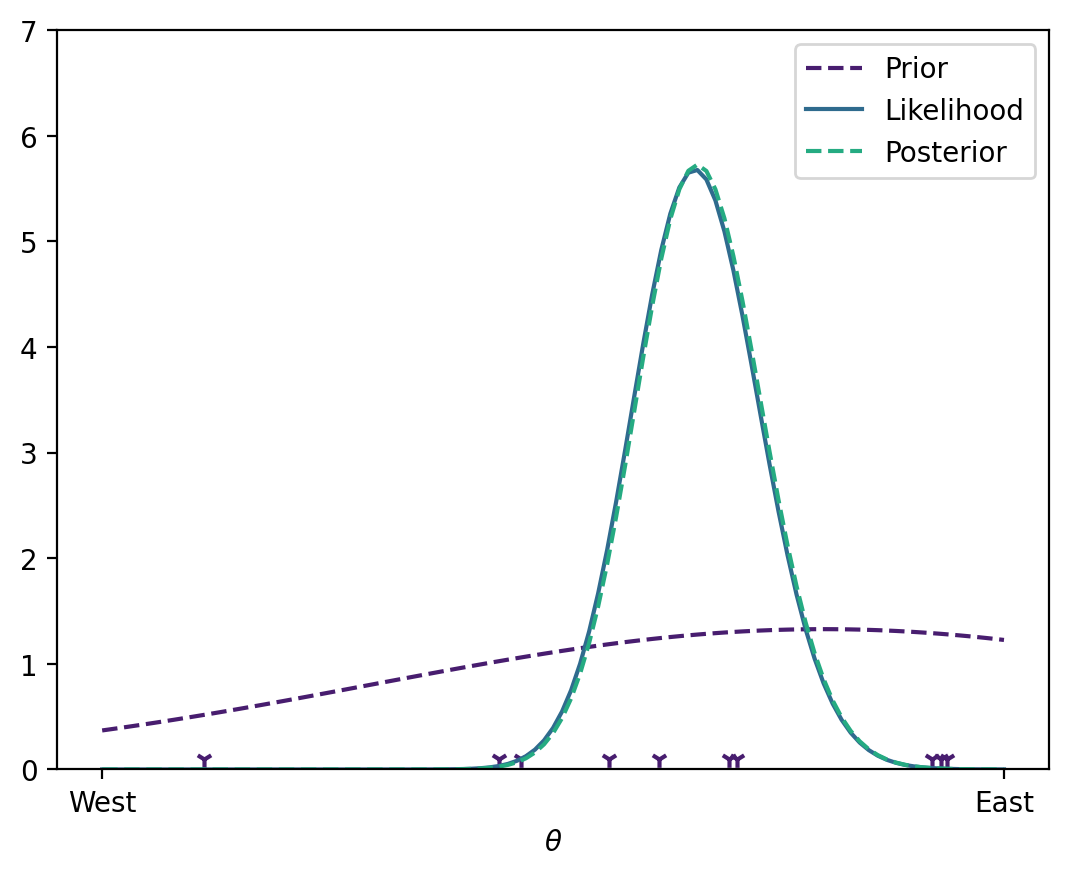

In [9]:
def update_probs(prior_probs, lik, binwidth=0.01):
    post_probs = prior_probs * lik
    return post_probs / np.sum(post_probs) / binwidth

grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.5)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.5), linestyle='dashed', label='Prior')
plt.plot(grid, lik_x, linestyle='solid', label='Likelihood')
plt.plot(grid, posterior_probs, linestyle='dashed', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x)+.1, marker='1')
plt.ylim(0, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()

In questa situazione, è evidente che una distribuzione a priori come quella descritta in precedenza, che definiremo "debolmente informativa", ha un impatto trascurabile e la distribuzione a posteriori risulta quasi indistinguibile dalla verosimiglianza (che è stata normalizzata).

Ora, esamineremo come si comporta una distribuzione a priori maggiormente informativa.

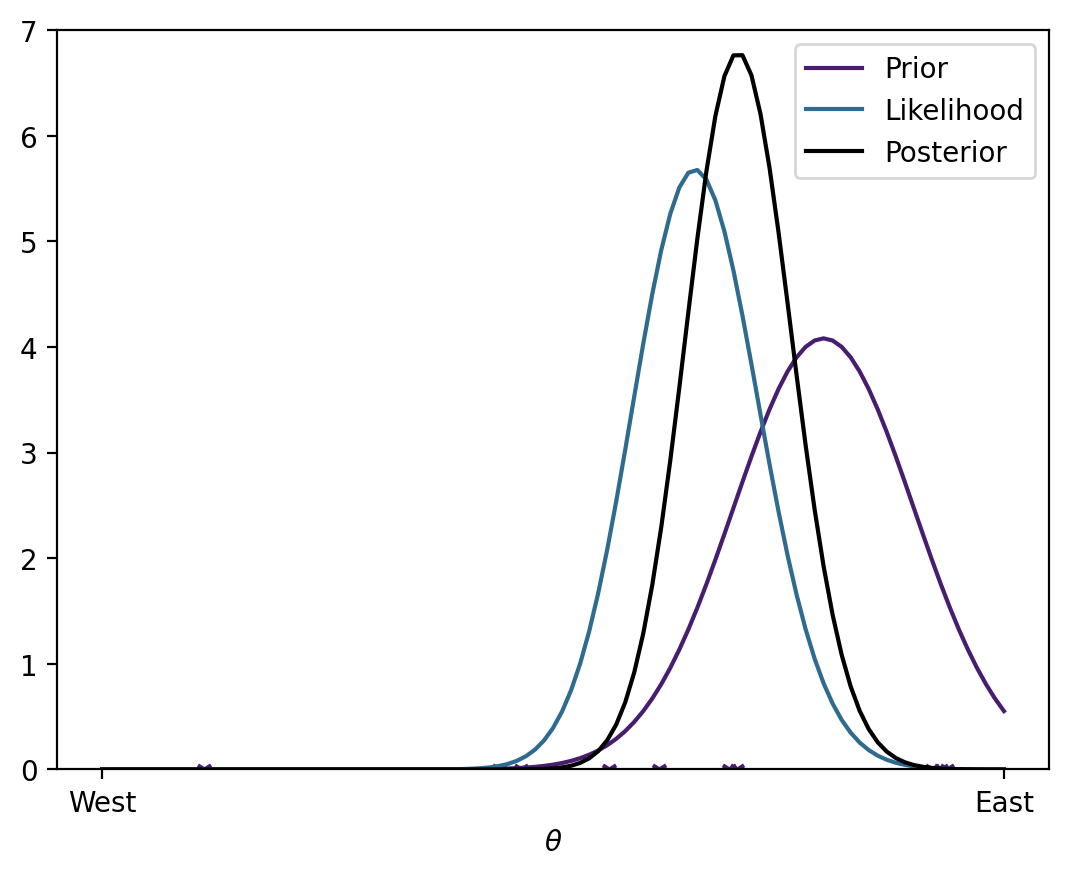

In [11]:
grid = np.linspace(0, 1, num=101)

# Prior probabilities
prior_probs = dnorm_trunc(grid, mean=0.8, sd=0.1)

# Likelihood values
lik_x = compute_lik(dat_x)

# Posterior probabilities
posterior_probs = update_probs(prior_probs, lik_x)

# Plotting
plt.plot(grid, dnorm_trunc(grid, mean=0.8, sd=0.1), label='Prior')
plt.plot(grid, lik_x, linestyle='solid', label='Likelihood')
plt.plot(grid, posterior_probs, color='black', label='Posterior')
plt.scatter(dat_x, np.zeros_like(dat_x), marker='1')
plt.ylim(0, 7)
plt.xlabel(r'$\theta$')
plt.ylabel('')
plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()

Il grafico illustra le tre distribuzioni coinvolte nell'aggiornamento bayesiano.

1. La curva tratteggiata rossa rappresenta la distribuzione a priori di $\theta$. Questa curva riflette le nostre credenze iniziali o le aspettative riguardo ai possibili valori di $\theta$ prima di effettuare qualsiasi osservazione. Nel nostro esempio, la distribuzione a priori è una distribuzione normale con una media di 0.8 e una deviazione standard di 0.1. Questo implica che, prima di raccogliere dati, prevediamo che il valore di $\theta$ sia prossimo a 0.8, con una limitata variazione intorno a questa media.

2. La curva continua blu rappresenta la verosimiglianza dei dati osservati dato un valore specifico di $\theta$. In altre parole, essa descrive quanto i dati osservati supportano ogni possibile valore di $\theta$. La forma della curva indica quale valore di $\theta$ risulta più plausibile in base a ciò che è stato osservato. Maggiore è l'altezza della curva in un determinato punto, maggiore è il supporto fornito dai dati a quel valore di $\theta$.

3. La curva tratteggiata nera rappresenta la distribuzione a posteriori di $\theta$. Questa curva rappresenta la nostra stima aggiornata di $\theta$ dopo aver incorporato i dati osservati e le credenze iniziali attraverso il calcolo bayesiano. La distribuzione a posteriori combina la distribuzione a priori con la verosimiglianza dei dati, fornendo una stima più precisa e informativa di $\theta$. In sostanza, essa riflette la nostra comprensione aggiornata del valore di $\theta$ più probabile, tenendo conto sia delle informazioni iniziali che dei dati osservati.

   - Il valore di $\theta$ più probabile nella distribuzione a posteriori corrisponde al punto in cui la curva raggiunge l'apice, ovvero il valore di $\theta$ in cui la densità è massima. Questo punto rappresenta la stima del parametro $\theta$ che appare più plausibile alla luce dei dati osservati e delle credenze iniziali.
   - Inoltre, la distribuzione a posteriori fornisce indicazioni sulla nostra incertezza riguardo al valore di $\theta$. Se la distribuzione a posteriori è concentrata attorno a un valore specifico di $\theta$ e presenta un picco netto, ciò suggerisce che siamo più sicuri nella stima di $\theta$ e l'incertezza è ridotta. In altre parole, i dati osservati sono informativi e hanno ridotto l'incertezza sul valore di $\theta$. Invece, se la distribuzione a posteriori è ampia e ha una forma meno definita, implica maggiore incertezza nella stima di $\theta$. Questo può accadere quando i dati osservati sono scarsi o poco informativi, oppure se la distribuzione a priori era ampia, consentendo una vasta gamma di valori di $\theta$. In sintesi, la forma della distribuzione a posteriori riflette quanto i dati raccolti ci abbiano aiutato a restringere le possibili valutazioni di $\theta$.

## Linguaggi di programmazione probabilistici

L'esempio precedente illustra il problema cui la modellazione bayesiana intende rispondere e la soluzione che essa propone per risolverlo. Finora abbiamo illustrato la logica dell'aggiornamento bayesiano, senza ancora entrare nei dettagli computazionali che verranno approfonditi nei prossimi capitoli.

Per ora, è importante sottolineare che l'attuale statistica bayesiana fa un ampio utilizzo di un linguaggio di programmazione probabilistico (*Probabilistic Programming Language*, PPL) implementato su computer per eseguire l'aggiornamento bayesiano. Questo approccio ha rivoluzionato il modo in cui si svolgevano le analisi statistiche bayesiane anche solo pochi decenni fa. L'adozione di tali metodi computazionali ha semplificato la formulazione di modelli statistici complessi, abbassando la soglia delle competenze matematiche e computazionali richieste, e agevolando il processo di modellazione bayesiana. Inoltre, questi strumenti hanno aperto nuove opportunità per affrontare problemi di analisi dei dati che, in passato, sarebbero stati notevolmente complessi da trattare.

## Notazione

Per chiarire la notazione, nel seguito useremo $y$ per rappresentare i dati e $\theta$ per indicare i parametri incogniti di un modello statistico. Entrambi, $y$ e $\theta$, saranno trattati come variabili casuali. Utilizzeremo invece $x$ per denotare le quantità note, come ad esempio i predittori di un modello lineare.

Per rappresentare in modo conciso i modelli probabilistici, adotteremo una notazione particolare. Ad esempio, invece di scrivere $p(\theta) = Beta(1, 1)$, scriveremo semplicemente $\theta \sim Beta(1, 1)$. Il simbolo "$\sim$" viene comunemente letto come "è distribuito come". Possiamo anche interpretarlo nel senso che $\theta$ è un campione casuale estratto dalla distribuzione Beta(1, 1). Allo stesso modo, la verosimiglianza di un modello binomiale sarà scritta come $y \sim \text{Bin}(n, \theta)$.

## La distribuzione a priori

Nell'approccio bayesiano, i parametri della distribuzione di riferimento non sono considerati come costanti incognite, bensì come variabili casuali, e di conseguenza sono descritti attraverso una distribuzione di probabilità a priori. Tale distribuzione a priori conferisce un grado superiore di certezza ai valori dei parametri che appaiono più verosimili in base alle informazioni disponibili. Idealmente, le credenze a priori che guidano questa scelta dovrebbero derivare da motivazioni ben fondate, come i risultati di ricerche precedenti.

Le distribuzioni a priori possono variare in base al grado di certezza con cui impegnano il ricercatore a considerare credibile un particolare intervallo di valori dei parametri. Un caso estremo è rappresentato dalle distribuzioni a priori *non informative*, che indicano una completa mancanza di conoscenza pregressa e assegnano lo stesso livello di credibilità a tutti i valori dei parametri. D'altra parte, le distribuzioni a priori informative possono essere classificate come *debolmente informative* o *fortemente informative*, a seconda di come lo sperimentatore distribuisce la credibilità all'interno dello spazio dei parametri. In situazioni estreme, la credenza a priori può concentrarsi completamente su un singolo valore del parametro.

## La verosimiglianza marginale

La formula completa della distribuzione a posteriori si esprime come segue:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{\int_{\Theta}p(y \mid \theta) p(\theta) \,d\theta} \quad \text{per} \quad \theta \in \Theta, 
$$

dove $\Theta$ rappresenta lo spazio dei possibili valori del parametro $\theta$.

Per calcolare $p(\theta \mid y)$, è necessario dividere il prodotto tra la distribuzione a priori e la verosimiglianza per una costante di normalizzazione. Questa costante, chiamata *verosimiglianza marginale*, viene introdotta per garantire che $p(\theta \mid y)$ abbia un'area unitaria sotto la curva. Tuttavia, l'integrale al denominatore della formula {eq}`eq-bayes-intro` spesso risulta difficile da risolvere analiticamente. Di conseguenza, l'inferenza bayesiana procede generalmente mediante metodi di approssimazione numerica.

### Metodi di stima della distribuzione a posteriori

Ci sono due principali strategie per calcolare la distribuzione a posteriori:

1. **Metodo esatto**: Questo approccio è applicabile quando la distribuzione a priori e la funzione di verosimiglianza appartengono alla stessa classe di distribuzioni, note come *distribuzioni a priori coniugate*. Quando ciò accade, la distribuzione a posteriori può essere determinata analiticamente, senza necessità di approssimazioni. Questo metodo è elegante e computazionalmente efficiente, ma ha una portata limitata, in quanto le distribuzioni a priori coniugate esistono solo per certe combinazioni specifiche di distribuzioni a priori e verosimiglianze.
2. **Metodo approssimato**: Quando il metodo esatto non può essere utilizzato, ad esempio, quando le distribuzioni a priori e le verosimiglianze non sono coniugate, si può ricorrere al metodo approssimato. Questo implica l'uso di algoritmi computazionalmente intensivi, come le Catene di Markov Monte Carlo (MCMC), per stimare la distribuzione a posteriori. Sebbene questo approccio sia più flessibile e applicabile a una vasta gamma di scenari, richiede più risorse computazionali e può essere più lento rispetto al metodo esatto.

## Il flusso di lavoro bayesiano

Il procedimento dell'aggiornamento bayesiano può essere paragonato al gesto di "girare la manovella bayesiana" (*turning the Bayesian Crank*), una metafora che enfatizza la sua applicabilità a una vasta gamma di contesti di ricerca. L'analisi bayesiana si articola in una serie di fasi ben definite, ciascuna con un ruolo chiave, che sono sintetizzate, per esempio, nella seguente figura tratta da articolo di {cite:t}`baribault2023troubleshooting`.

```{image} ../images/bayesian_workflow.png
:height: 550px
:align: center
```

Nel flusso di lavoro bayesiano possiamo evidenziare i seguenti passi.

1. **Studio di simulazione**: Durante la fase di simulazione, è necessario generare dati sintetici che aderiscano fedelmente alla distribuzione prevista dalla specificazione del modello, sfruttando valori parametrici noti o veritieri. La simulazione deve emulare con precisione il disegno sperimentale preposto, replicando, per esempio, il numero di partecipanti previsti e le sequenze di stimoli pianificate. L'obiettivo primario è di determinare se le condizioni delineate per lo studio (quantità di partecipanti, variabilità delle condizioni, numero di tentativi, etc.) siano adeguate per garantire una raccolta dati sufficientemente robusta da permettere una stima accurata dei parametri veri del modello teorizzato.
2. **Identificazione e raccolta dei dati**: In questa fase si procede con l'acquisizione e l'analisi esplorativa dei dati inerenti alla questione di ricerca. Questa operazione comporta un'indagine dettagliata delle caratteristiche intrinseche del dataset, al fine di comprenderne la struttura e rilevare eventuali anomalie o discrepanze che potrebbero influenzare le analisi successive.
3. **Selezione del modello statistico**: In questa fase si procede con la formulazione di un modello statistico adeguato in risposta alle questioni poste dalla ricerca. La determinazione del modello appropriato deve derivare da una profonda comprensione teorica del fenomeno in esame, oltre che dalla considerazione di criteri statistici e metodologici pertinenti.
4. **Definizione delle distribuzioni a priori**: Questa fase richiede di stabilire le distribuzioni a priori per i parametri del modello, un passaggio che può essere influenzato da giudizi soggettivi ma che deve essere guidato da una logica coerente e plausibile.
5. **Calcolo delle distribuzioni a posteriori**: In questa fase, si determinano le distribuzioni a posteriori utilizzando metodi analitici o algoritmi computazionali. 
6. **Troubleshooting**: È cruciale garantire una corretta convergenza degli algoritmi per assicurare la validità delle inferenze ottenute. Pertanto, è imperativo eseguire una serie di controlli computazionali e diagnostici per valutare la correttezza del campionamento e la funzionalità del modello, tenendo in considerazione metriche come $ \hat{R} $, divergenze, BFMI, ESS e $ k $.
7. **Controlli di coerenza**: Questi rappresentano un'integrazione fondamentale alle verifiche computazionali, essendo orientati alla valutazione delle premesse fondamentali e delle previsioni relative al comportamento del modello. Tali controlli sono progettati per identificare eventuali errori nella specificazione del modello nel contesto dell'indagine specifica. È cruciale condurre una valutazione predittiva a posteriori per assicurare che le previsioni del modello siano coerenti con le informazioni disponibili; tale valutazione dovrebbe anche contemplare l'esame delle distribuzioni a priori selezionate, garantendo che siano in armonia con i dati empiricamente raccolti.
8. **Interpretazione e comunicazione dei risultati**: Nella fase finale, i risultati vengono interpretati nel contesto delle domande di ricerca e delle teorie sottostanti. Questa interpretazione serve a integrare i risultati dell'analisi nel più ampio quadro di comprensione del fenomeno studiato, e a comunicare le conclusioni in modo chiaro ed efficace.

## Commenti e considerazioni finali 

L'approccio bayesiano offre una modalità distintiva per gestire l'incertezza associata ai parametri di interesse, distinguendosi nettamente dalla metodologia classica. Contrariamente all'idea che i parametri siano valori fissi e ignoti, l'approccio bayesiano li considera come quantità probabilistiche, attribuendo loro una distribuzione a priori che rappresenta le nostre credenze e intuizioni iniziali prima di condurre l'esperimento. Mediante l'applicazione del teorema di Bayes, queste credenze vengono modificate e affinate sulla base dei dati raccolti, portando alla definizione della distribuzione a posteriori. Quest'ultima esprime una visione aggiornata dell'incertezza, incorporando sia l'evidenza empirica che le informazioni preesistenti.

La forza dell'approccio bayesiano sta nella sua capacità di integrare le conoscenze pregresse con le nuove osservazioni, fornendo stime del parametro di interesse sia più accurate che ricche di significato. Questa metodologia va oltre la semplice analisi, guidando il processo decisionale e permettendo di affrontare l'incertezza con una comprensione profonda, coniugando conoscenze teoriche ed evidenze empiriche. In ultima analisi, l'approccio bayesiano non è solo un metodo statistico, ma uno strumento decisionale che valorizza l'interazione dinamica tra teoria ed esperienza.